In [1]:
import os
import numpy as np
import csv
import random
import time
import pickle
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
os.chdir("C:\\Users\\Samir\\Desktop\\ENSAE\\GMML")

In [3]:
wordnet_mammal_file = 'wordnet_mammal_hypernyms.txt'

In [4]:
def load_wordnetload_wor (wordnet_path):
    network = {}
    with open(wordnet_path, 'r') as f:
        reader = csv.reader(f, delimiter='\t')
        for row in reader:
            if not row[0]==row[1]:
                if row[0] in network:
                    network[row[0]].append(row[1])
                else:
                    network.update({row[0]:[row[1]]})
    return network

In [5]:
network = load_wordnetload_wor(wordnet_mammal_file)
network

{'kangaroo.n.01': ['marsupial.n.01', 'mammal.n.01', 'metatherian.n.01'],
 'domestic_goat.n.01': ['even-toed_ungulate.n.01',
  'ruminant.n.01',
  'goat.n.01',
  'placental.n.01',
  'bovid.n.01',
  'ungulate.n.01',
  'mammal.n.01'],
 'rock_squirrel.n.01': ['ground_squirrel.n.02',
  'squirrel.n.01',
  'rodent.n.01',
  'mammal.n.01',
  'placental.n.01'],
 'vizsla.n.01': ['dog.n.01',
  'placental.n.01',
  'sporting_dog.n.01',
  'mammal.n.01',
  'carnivore.n.01',
  'canine.n.02',
  'pointer.n.04',
  'hunting_dog.n.01'],
 'dandie_dinmont.n.01': ['mammal.n.01',
  'terrier.n.01',
  'dog.n.01',
  'hunting_dog.n.01',
  'canine.n.02',
  'placental.n.01',
  'carnivore.n.01'],
 'broodmare.n.01': ['horse.n.01',
  'ungulate.n.01',
  'odd-toed_ungulate.n.01',
  'placental.n.01',
  'mare.n.01',
  'mammal.n.01',
  'equine.n.01'],
 'lesser_kudu.n.01': ['placental.n.01',
  'kudu.n.01',
  'even-toed_ungulate.n.01',
  'mammal.n.01',
  'antelope.n.01',
  'bovid.n.01',
  'ruminant.n.01',
  'ungulate.n.01'],
 '

In [6]:
def dist(u, v): 
    """Distance de Poincaré (équation 1 de l'article)"""
    return 1 + 2*np.dot(u - v, u - v)/ \
             ((1-np.dot(u, u))*(1-np.dot(v, v)) + EPSILON)

In [7]:
def partial_der(theta, x, gamma): 
    """Dérivée partielle par rapport à theta (equation 4 de l'article)"""
    alpha = (1.0-np.dot(theta, theta))
    norm_x = np.dot(x, x)
    beta = (1-norm_x)
    gamma = gamma
    return 4.0/(beta * np.sqrt(gamma*gamma - 1) + EPSILON)*((norm_x- 2*np.dot(theta, x)+1)/(pow(alpha,2)+EPSILON)*theta - x/(alpha + EPSILON))

In [8]:
def update(emb, error_, lr):
    """Equation d'update (equation 5)"""
    try:
        update =  lr*pow((1 - np.dot(emb,emb)), 2)*error_/4
        emb = emb - update
        if (np.dot(emb, emb) >= 1):
            emb = emb/sqrt(np.dot(emb, emb)) - EPSILON
        return emb
    except Exception as e:
        print (e)

In [9]:
#connaître les n noeuds les plus proches d'un autre noeud
def distance_min(node, n):
    #distance de chaque noeud au noeud node
    distance_to_node = np.zeros(len(vocab))
    #index des mots ayant la plus petite distance aux mots node
    index_minimum = np.zeros(n)
    for i in range(len(vocab)):
        distance_to_node[i] = dist(emb[node],emb[vocab[i]])
    index_minimum = np.argpartition(distance_to_node, n)
    for i in range(n):
        print(vocab[index_minimum[i]])

In [10]:
def get_vocabulary(network):
    vocab = list(emb.keys())
    vocab_weights = np.zeros(len(vocab))
    for key in network:
        for u in network[key]:
            vocab_weights[vocab.index(u)]+=1
    vocab_weights = vocab_weights / np.sum(vocab_weights)
    return vocab, vocab_weights

In [11]:
def initialize_embedding(network, embedding_size):
    """Comme dans l'article, on initialise la position des noeuds entre 0.001 et -0.001"""
    emb = {}
    gap = 1e-3
    for a in network:
        for b in network[a]:
            emb[b] = np.random.uniform(low=-gap, high=gap, size=(embedding_size,))
        emb[a] = np.random.uniform(low=-gap, high=gap, size=(embedding_size,))
    return emb

In [12]:
def get_negative_candidates(network, vocab, vocab_weights, u, num_negs):
    """Retourne une liste de mots qui ne sont pas liés à celui donné en entrée"""
    negs = []
    i = 0
    while (len(negs) < num_negs):
        neg = np.random.choice(vocab, p=vocab_weights)
        #neg = vocab[np.searchsorted(vocab_weights.cumsum(), random.random())]
        if not (neg in network[u] or u in network[neg] or neg == u): # neg ne doit pas etre lié à u et vice versa
            #or neg in negs
            negs.append(neg)
    return negs

In [13]:
def euclidian_dist(u,v):
    """Distance euclidienne"""
    return np.dot(u-v,u-v)

In [14]:
def poincare_dist(gamma): 
    """Distance de Poincaré (équation 1 de l'article)"""
    return np.arccosh(gamma)

In [15]:
def compute_gamma(vec1, vec2):
    euclidean_dists = np.linalg.norm(vec1 - vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    alpha = 1-norm1**2
    beta = 1-norm2**2
    gamma = 1 + 2*euclidean_dists/(alpha*beta)
    return gamma

In [16]:
def deriv_poincare_theta(theta, x, gamma): 
    """Dérivée partielle par rapport à theta de la distance de Poincare (equation 4 de l'article)"""
    alpha = (1.0-np.dot(theta, theta))
    norm_x = np.dot(x, x)
    beta = (1-norm_x)
    gamma = gamma
    return 4.0/(beta * np.sqrt(gamma*gamma - 1))*((norm_x- 2*np.dot(theta, x)+1)/(pow(alpha,2))*theta - x/(alpha))

In [17]:
#Initialisation des variables

embedding_size = 2 #dimension des vecteurs d'entrainement
emb = initialize_embedding(network, embedding_size)# embedding of nodes of network

#epochs
num_epochs = 50

#burn-in, nombre d'épochs
nb_burn_in = 10

#nombre de nodes negatives pour l'entrainement
num_negs = 20

#learning rate
lr = 1e-2

#learning rate pour le burn-in
learning_rate_burn_in = 0.00001

EPSILON = 0.00001 # evite l'overflow

vocab, vocab_weights = get_vocabulary(network)

In [18]:
# Randomly uniform distribution
for a in network:
    for b in network[a]:
        emb[b] = np.random.uniform(low=-0.001, high=0.001, size=(embedding_size,))
    emb[a] = np.random.uniform(low=-0.001, high=0.001, size=(embedding_size,))

vocab = list(emb.keys())

In [19]:
#on supprime l'origine de la liste du vocabulaire, car il est lié à tous les mots
index_origin = vocab.index("mammal.n.01")

del vocab[index_origin]
vocab_weights = np.delete(vocab_weights, index_origin)

vocab_weights = vocab_weights/sum(vocab_weights)

In [20]:
#random.shuffle(vocab)

# the leave nodes are not connected to anything
for a in emb:
    if not a in network:
        network[a] = []

last_time = time.time()
for epoch in range(num_epochs):
    if epoch < nb_burn_in:
        burn_in = True
    else:
        burn_in = False
    for u in vocab:
        if not network[u]: # une node
            continue
        v = random.choice(network[u]) # u et v sont liés
        gamma_u_v = compute_gamma(emb[u], emb[v])
        dist_p_u_v = poincare_dist(gamma_u_v) # distance between the related nodes
        
        negs = [] # pairs of not related nodes, the first node in the pair is `pos1`
        gamma_u_negs = [] # distances entre nodes qui ne sont pas liées
        dist_negs = [] # distances entre nodes qui ne sont pas liées
        negs = get_negative_candidates(network, vocab, vocab_weights, u, num_negs) 
        for neg in negs:
            gamma_u_neg = compute_gamma(emb[u], emb[neg])
            gamma_u_negs.append(gamma_u_neg)
            dist_neg = poincare_dist(gamma_u_neg)
            dist_negs.append(dist_neg)
                
        loss_den = 0.0
        
        # eqn6
        for dist_neg in dist_negs:
            loss_den += np.exp(-1*dist_neg)
        loss = -1*dist_p_u_v - np.log(loss_den)
        
        # derivative of loss wrt positive relation [d(u, v)]
        der_p = -1
        der_negs = []
        # derivative of loss wrt negative relation [d(u, v')]
        for dist_neg in dist_negs:
            der_negs.append(np.exp(-1*dist_neg)/(loss_den))
        # derivative of loss wrt pos1
        der_p_u = der_p * deriv_poincare_theta(emb[u], emb[v], gamma_u_v)
        # derivative of loss wrt pos2
        der_p_v = der_p * deriv_poincare_theta(emb[v], emb[u], gamma_u_v)
        
        der_negs_final = []        
        for (der_neg, neg, gamma_u_neg) in list(zip(der_negs, negs, gamma_u_negs)):
            # derivative of loss wrt second element of the pair in neg
            der_neg1 = der_neg * deriv_poincare_theta(emb[neg], emb[u], gamma_u_neg)
            # derivative of loss wrt first element of the pair in neg
            der_neg0 = der_neg * deriv_poincare_theta(emb[u], emb[neg], gamma_u_neg)
            der_negs_final.append([der_neg0, der_neg1])
        
        # update embeddings now
        if burn_in:
            emb[u] = update(emb[u], -1*der_p_u, learning_rate_burn_in)
            emb[v] = update(emb[v], -1*der_p_v, learning_rate_burn_in)  
        else:
            emb[u] = update(emb[u], -1*der_p_u, 1/(epoch+1))
            emb[v] = update(emb[v], -1*der_p_v, 1/(epoch+1))
        for (neg, der_neg) in list(zip(negs, der_negs_final)):
            if burn_in:
                emb[u] = update(emb[u], -1*der_neg[0], learning_rate_burn_in)
                emb[neg] = update(emb[neg], -1*der_neg[1], learning_rate_burn_in)
            else:
                emb[u] = update(emb[u], -1*der_neg[0], 1/(epoch+1))
                emb[neg] = update(emb[neg], -1*der_neg[1], 1/(epoch+1))     
                
    print('Epoch #%d, temps d\'exécution: %.2f seconds' % (epoch + 1, time.time() - last_time))
    last_time = time.time()
#pickle.dump(emb, open('data/train.pickle', 'wb'))

Epoch #1, temps d'exécution: 6.53 seconds
Epoch #2, temps d'exécution: 6.43 seconds


KeyboardInterrupt: 

In [ ]:
distance_min("carnivore.n.01", 10)

## Résultats

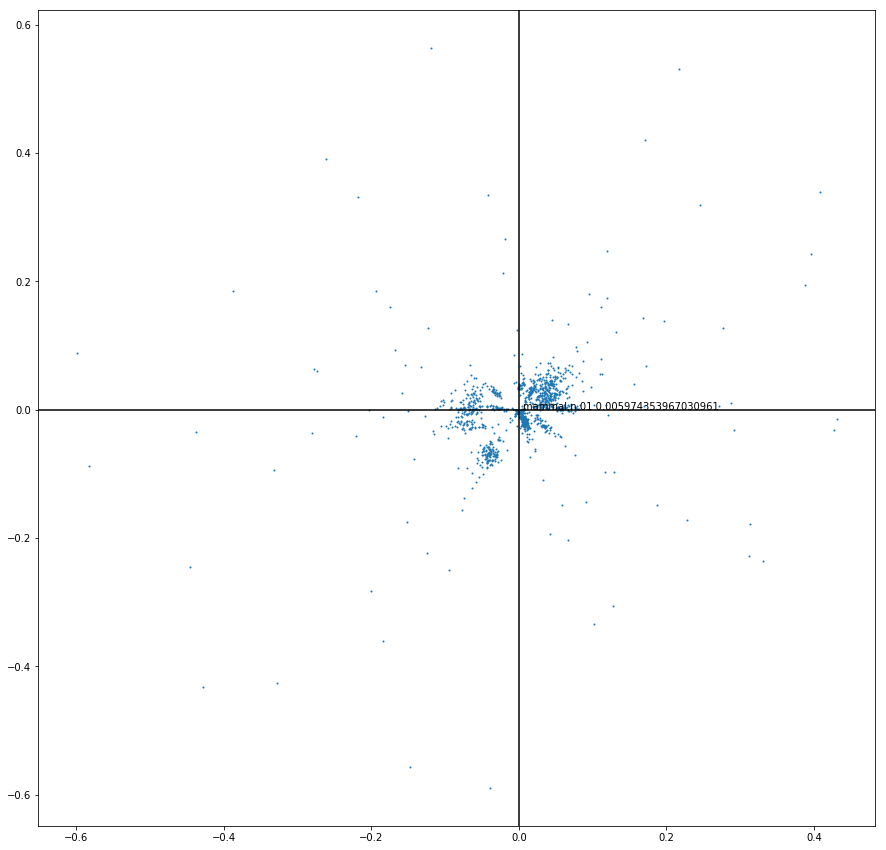

In [45]:
fig=plt.figure(figsize=(15,15))
names = []
positions_x = []
positions_y = []
for key in emb:
    names.append(key)
    positions_x.append(emb[key][0])
    positions_y.append(emb[key][1])

plt.scatter(positions_x,positions_y, s=1)
k=1
plt.text(positions_x[k], positions_y[k], names[k] + " " + str(positions_x[k]), fontsize=10)

# circle = plt.Circle((0, 0), 1, color='g',fill=False)

# plt.axis([-1,1,-1,1])
# ax=fig.add_subplot(1,1,1)
# ax.add_patch(circle)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.show()